In [1]:
from pylablib.devices import Thorlabs
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.animation as animation
import time
from IPython.display import display, Image, clear_output

In [2]:
device = Thorlabs.list_kinesis_devices()[0][0]
stage = Thorlabs.KinesisMotor(device)

c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:230: UserWarning: model number SCC201 doesn't match the device ID prefix 40((BSC101|SSC20.))
  warnings.warn("model number {} doesn't match the device ID prefix {}({})".format(model_no,port,port_model_no))
c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model SCC201; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


In [3]:
def calculate_focus_score(image, blur):
   image_filtered = cv.medianBlur(image, blur)
   laplacian = cv.Laplacian(image_filtered, cv.CV_64F)
   focus_score = laplacian.var()
   return focus_score

In [4]:
"""
To find scale head to Thorlabs.KinesisMotor and look for 
"_get_step_scale". Look for the model NRT150.
"""
scale = 409600E3
distance_to_move = -0.0001 # m
stage.setup_velocity(min_velocity = 0, max_velocity = 1000000000, acceleration = 10000000000)
stage.move_by(int(distance_to_move*scale), scale = False)

In [5]:
from camera_controllers import CameraController

camera = CameraController("IDS", 2)

In [6]:
camera.get_camera_ready()
cam_params = {"exposure": 5000}
camera.set_properties(cam_params)

17

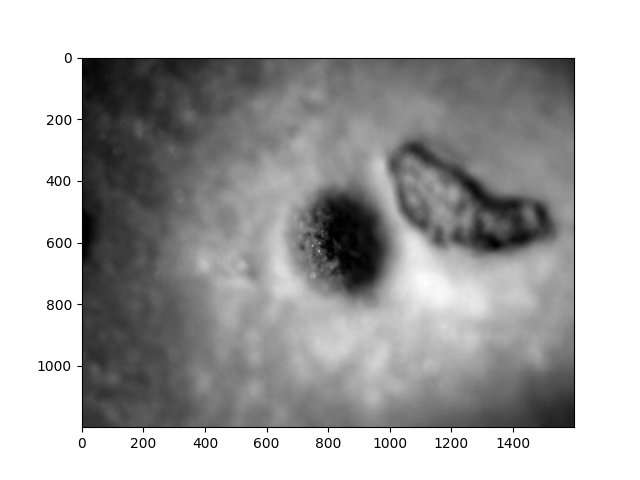

No such comm: 342de89344664d5984ef420bbf04c1ba


In [23]:
%matplotlib widget
def get_frame():
    img = camera.get_image()
    return img



fig, ax = plt.subplots()
im = ax.imshow(get_frame(), cmap = 'gray')

# Update function for the animation
def update_frame(*args):
    im.set_array(get_frame())
    return im

def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x, y = int(event.xdata), int(event.ydata)
        ax.scatter(x, y, marker = 'x', color = 'r')

# Create an animation object
ani = animation.FuncAnimation(fig, update_frame, interval = 1, blit = True, cache_frame_data = False)
fig.canvas.mpl_connect('button_press_event', onclick)

In [24]:
plt.close()

In [ ]:
from pylablib.devices import Thorlabs
from camera_controllers import CameraController

device = Thorlabs.list_kinesis_devices()[0][0]
stage = Thorlabs.KinesisMotor(device)
camera = CameraController("IDS", 2)

In [1]:
import sys
import numpy as np
from PyQt5.QtWidgets import QApplication, QVBoxLayout, QWidget
from PyQt5.QtCore import QTimer
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from camera_controllers import CameraController

class LiveCameraPlot(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()
        self.initCamera()

    def initUI(self):
        # Create a vertical layout
        layout = QVBoxLayout()

        # Create a Matplotlib figure
        self.fig = Figure()
        self.canvas = FigureCanvas(self.fig)
        layout.addWidget(self.canvas)
        self.ax = self.fig.add_subplot(111)

        # Set window properties
        self.setLayout(layout)
        self.setWindowTitle('Camera Live Feed with Matplotlib')
        self.setGeometry(300, 300, 800, 600)
        self.show()

    def initCamera(self):
        # Initialize the camera
        self.camera = CameraController("IDS", 2)
        self.camera.get_camera_ready()
        cam_params = {"exposure": 5000}
        self.camera.set_properties(cam_params)

        # Set up a timer to capture images every 100 milliseconds
        self.timer = QTimer(self)
        self.timer.timeout.connect(self.updatePlot)
        self.timer.start(100)

    def updatePlot(self):
        # Capture an image from the camera
        frame = self.camera.get_image()

        # Update the plot with the new image
        if frame is not None:
            self.ax.clear()
            self.ax.imshow(frame, aspect='auto', cmap = 'gray')  # Adjust as needed depending on the image dimensions
            self.canvas.draw()

    def closeEvent(self, event):
        self.camera.release()  # Release the camera properly
        event.accept()

if __name__ == '__main__':
    app = QApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    ex = LiveCameraPlot()
    sys.exit(app.exec_())


AttributeError: 'CameraController' object has no attribute 'release'

SystemExit: 0

c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget
from PyQt5.QtCore import QThread, QTimer
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.animation as animation

stage.setup_velocity(min_velocity = 0, max_velocity = 100000000, acceleration = 1000000000)
camera.get_camera_ready()
cam_params = {"exposure": 5000}
camera.set_properties(cam_params)

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)
        self.camera = camera
        image = camera.get_image()
        self.im = self.axes.imshow(image, cmap='gray')

    def update_plot(self):
        image = self.camera.get_image()
        self.im.set_array(image)

class App(QMainWindow):
    def __init__(self):
        super().__init__()
        self.title = 'Keyboard Event and Camera Feed Example'
        self.left = 100
        self.top = 100
        self.width = 640
        self.height = 480
        self.initUI()

    def initUI(self):
        self.setWindowTitle(self.title)
        self.setGeometry(self.left, self.top, self.width, self.height)

        # Create Matplotlib canvas
        self.canvas = MplCanvas(self, width=5, height=4, dpi=100)
        layout = QVBoxLayout()
        widget = QWidget()
        widget.setLayout(layout)
        layout.addWidget(self.canvas)
        self.setCentralWidget(widget)

        # Timer for updating the plot
        self.timer = QTimer()
        self.timer.setInterval(10)  # 50 ms = 20 fps
        self.timer.timeout.connect(self.canvas.update_plot)
        self.timer.start()

        self.show()

    def keyPressEvent(self, event):
        if event.key() == ord('A'):
            stage.jog("-")
        elif event.key() == ord('D'):
            stage.jog("+")
        elif event.key() == ord("K"):
            stage.stop()

def run_app():
    # Check if QApplication instance already exists; create it if not
    app = QApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    ex = App()
    app.exec_()

run_app()

In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QVBoxLayout, QWidget, QPushButton
from PyQt5.QtCore import QTimer, QThread
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from pylablib.devices import Thorlabs
from camera_controllers import CameraController

In [2]:
def initStage():
        # Initialize the stage controller
        device = Thorlabs.list_kinesis_devices()[0][0]
        stage = Thorlabs.KinesisMotor(device)
        stage.setup_velocity(min_velocity=0, max_velocity=100000000, acceleration=1000000000)
        return stage
stage = initStage()

c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:230: UserWarning: model number SCC201 doesn't match the device ID prefix 40((BSC101|SSC20.))
  warnings.warn("model number {} doesn't match the device ID prefix {}({})".format(model_no,port,port_model_no))
c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model SCC201; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


In [3]:
class LiveCameraPlot(QWidget):
    def __init__(self, stage):
        super().__init__()
        self.stage = stage
        self.initUI()
        self.initCamera()

    def initUI(self):
        layout = QVBoxLayout()

        self.fig = Figure()
        self.canvas = FigureCanvas(self.fig)
        layout.addWidget(self.canvas)
        self.ax = self.fig.add_subplot(111)

        # Stage control buttons
        self.btnJogLeft = QPushButton('Jog Left', self)
        self.btnJogLeft.clicked.connect(lambda: self.stage.jog("-"))
        layout.addWidget(self.btnJogLeft)

        self.btnJogRight = QPushButton('Jog Right', self)
        self.btnJogRight.clicked.connect(lambda: self.stage.jog("+"))
        layout.addWidget(self.btnJogRight)

        self.btnStop = QPushButton('Stop', self)
        self.btnStop.clicked.connect(self.stage.stop)  # Corrected to not call the function immediately
        layout.addWidget(self.btnStop)

        self.setLayout(layout)
        self.setWindowTitle('Camera Live Feed with Matplotlib')
        self.setGeometry(300, 300, 800, 600)
        self.show()


    def initCamera(self):
        self.camera = CameraController("IDS", 2)
        self.camera.get_camera_ready()
        cam_params = {"exposure": 5000}
        self.camera.set_properties(cam_params)

        self.timer = QTimer(self)
        self.timer.timeout.connect(self.updatePlot)
        self.timer.start(100)

    def updatePlot(self):
        frame = self.camera.get_image()
        if frame is not None:
            self.ax.clear()
            self.ax.imshow(frame, aspect='auto', cmap='gray')
            self.canvas.draw()

    def closeEvent(self, event):
        self.camera.release()  # Release the camera properly
        event.accept()

if __name__ == '__main__':
    app = QApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    ex = LiveCameraPlot(stage)
    sys.exit(app.exec_())

AttributeError: 'CameraController' object has no attribute 'release'

SystemExit: 0

c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import sys
from PyQt5.QtWidgets import QApplication, QVBoxLayout, QWidget, QPushButton
from PyQt5.QtCore import QTimer, pyqtSignal, QObject, QThread
from threading import Thread
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from camera_controllers import CameraController

class StageWorker(QObject):
    # This class will handle stage operations in a separate thread
    def __init__(self, stage):
        super().__init__()
        self.stage = stage

    def jog_left(self):
        self.stage.jog("-")

    def jog_right(self):
        self.stage.jog("+")

    def stop(self):
        self.stage.stop()

class LiveCameraPlot(QWidget):
    def __init__(self, stage):
        super().__init__()
        self.stage = stage
        self.initUI()
        self.initCamera()
        self.initStageThread()

    def initUI(self):
        layout = QVBoxLayout()

        self.fig = Figure()
        self.canvas = FigureCanvas(self.fig)
        layout.addWidget(self.canvas)
        self.ax = self.fig.add_subplot(111)

        # Stage control buttons
        self.btnJogLeft = QPushButton('Jog Left', self)
        self.btnJogLeft.clicked.connect(self.stageWorker.jog_left)
        layout.addWidget(self.btnJogLeft)

        self.btnJogRight = QPushButton('Jog Right', self)
        self.btnJogRight.clicked.connect(self.stageWorker.jog_right)
        layout.addWidget(self.btnJogRight)

        self.btnStop = QPushButton('Stop', self)
        self.btnStop.clicked.connect(self.stageWorker.stop)
        layout.addWidget(self.btnStop)

        self.setLayout(layout)
        self.setWindowTitle('Camera Live Feed with Matplotlib')
        self.setGeometry(300, 300, 800, 600)
        self.show()

    def initCamera(self):
        self.camera = CameraController("IDS", 2)
        self.camera.get_camera_ready()
        cam_params = {"exposure": 5000}
        self.camera.set_properties(cam_params)

        self.timer = QTimer(self)
        self.timer.timeout.connect(self.updatePlot)
        self.timer.start(100)

    def initStageThread(self):
        # Create the stage worker and move it to a separate thread
        self.stageWorker = StageWorker(self.stage)
        self.stageThread = QThread()
        self.stageWorker.moveToThread(self.stageThread)
        self.stageThread.start()

    def updatePlot(self):
        frame = self.camera.get_image()
        if frame is not None:
            self.ax.clear()
            self.ax.imshow(frame, aspect='auto', cmap='gray')
            self.canvas.draw()

    def closeEvent(self, event):
        self.camera.release()  # Ensure the camera is released properly
        self.stageThread.quit()  # Stop the stage thread
        self.stageThread.wait()  # Wait for the stage thread to finish
        event.accept()

if __name__ == '__main__':
    app = QApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    ex = LiveCameraPlot(stage)
    sys.exit(app.exec_())


AttributeError: 'LiveCameraPlot' object has no attribute 'stageWorker'

In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget
from PyQt5.QtCore import QThread, QTimer, pyqtSignal
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from pylablib.devices import Thorlabs
from camera_controllers import CameraController

# Instantiate camera and stage controller
camera = CameraController("IDS", 2)
device = Thorlabs.list_kinesis_devices()[0][0]
stage = Thorlabs.KinesisMotor(device)

camera.get_camera_ready()
cam_params = {"exposure": 5000}
camera.set_properties(cam_params)

class StageController(QThread):
    def __init__(self):
        super().__init__()
        self.stage = stage
        self.stage.setup_velocity(min_velocity=0, max_velocity=100000000, acceleration=1000000000)

    def run(self):
        pass

    def jog_forward(self):
        self.stage.jog("+")

    def jog_backward(self):
        self.stage.jog("-")

    def stop(self):
        self.stage.stop()

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)
        self.camera = camera
        image = self.camera.get_image()
        self.im = self.axes.imshow(image, cmap='gray')

    def update_plot(self):
        image = self.camera.get_image()
        self.im.set_array(image)
        self.draw()

class App(QMainWindow):
    def __init__(self):
        super().__init__()
        self.title = 'Keyboard Event and Camera Feed Example'
        self.left = 100
        self.top = 100
        self.width = 640
        self.height = 480
        self.initUI()
        self.stage_controller = StageController()
        self.stage_controller.start()

    def initUI(self):
        self.setWindowTitle(self.title)
        self.setGeometry(self.left, self.top, self.width, self.height)

        # Create Matplotlib canvas
        self.canvas = MplCanvas(self, width=5, height=4, dpi=100)
        layout = QVBoxLayout()
        widget = QWidget()
        widget.setLayout(layout)
        layout.addWidget(self.canvas)
        self.setCentralWidget(widget)

        # Timer for updating the plot
        self.timer = QTimer()
        self.timer.setInterval(10)  # 100 ms for image update
        self.timer.timeout.connect(self.canvas.update_plot)
        self.timer.start()

        self.show()

    def keyPressEvent(self, event):
        if event.key() == ord('A'):
            self.stage_controller.jog_backward()
        elif event.key() == ord('D'):
            self.stage_controller.jog_forward()
        elif event.key() == ord("K"):
            self.stage_controller.stop()

def run_app():
    # Check if QApplication instance already exists; create it if not
    app = QApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    ex = App()
    app.exec_()

run_app()

c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:230: UserWarning: model number SCC201 doesn't match the device ID prefix 40((BSC101|SSC20.))
  warnings.warn("model number {} doesn't match the device ID prefix {}({})".format(model_no,port,port_model_no))
c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model SCC201; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


In [ ]:
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget
from PyQt5.QtCore import QThread, QTimer, pyqtSignal
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from pylablib.devices import Thorlabs
from camera_controllers import CameraController

# Initialize camera and stage
camera = CameraController("IDS", 2)
stage = Thorlabs.KinesisMotor("deviceID")

camera.get_camera_ready()
cam_params = {"exposure": 5000}
camera.set_properties(cam_params)

class CameraThread(QThread):
    updated_image = pyqtSignal(np.ndarray)

    def __init__(self, camera):
        super().__init__()
        self.camera = camera
        self.running = True

    def run(self):
        while self.running:
            image = self.camera.get_image()
            self.updated_image.emit(image)
    
    def stop(self):
        self.running = False

class StageController(QThread):
    def __init__(self, stage):
        super().__init__()
        self.stage = stage
        self.stage.setup_velocity(min_velocity=0, max_velocity=100000000, acceleration=1000000000)
    
    def jog_forward(self):
        self.stage.jog("+")

    def jog_backward(self):
        self.stage.jog("-")

    def stop(self):
        self.stage.stop()

class MplCanvas(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)
        self.axes.imshow(np.zeros((10, 10)), cmap='gray')  # placeholder for initial image

    def update_plot(self, image):
        self.axes.imshow(image, cmap='gray', aspect='auto')
        self.draw()

class App(QMainWindow):
    def __init__(self, camera_thread, stage_controller):
        super().__init__()
        self.camera_thread = camera_thread
        self.stage_controller = stage_controller
        self.initUI()

    def initUI(self):
        self.setWindowTitle('Camera and Stage Controller')
        self.setGeometry(100, 100, 640, 480)

        self.canvas = MplCanvas(self, width=5, height=4, dpi=100)
        layout = QVBoxLayout()
        widget = QWidget()
        widget.setLayout(layout)
        layout.addWidget(self.canvas)
        self.setCentralWidget(widget)

        self.camera_thread.updated_image.connect(self.canvas.update_plot)
        self.camera_thread.start()
        self.stage_controller.start()

        self.show()

    def keyPressEvent(self, event):
        if event.key() == ord('A'):
            self.stage_controller.jog_backward()
        elif event.key() == ord('D'):
            self.stage_controller.jog_forward()
        elif event.key() == ord("K"):
            self.stage_controller.stop()

    def closeEvent(self, event):
        self.camera_thread.stop()
        self.stage_controller.stop()
        event.accept()

def run_app():
    app = QApplication(sys.argv)
    camera_thread = CameraThread(camera)
    stage_controller = StageController(stage)
    ex = App(camera_thread, stage_controller)
    sys.exit(app.exec_())

run_app()